# Loan Default Prediction Dataset 📊  
This dataset is used for **Loan Default Prediction** and is sourced from Kaggle.  

🔗 **Dataset Link:** [Loan Default Dataset on Kaggle](https://www.kaggle.com/datasets/nikhil1e9/loan-default/data)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    precision_recall_fscore_support,
    make_scorer,
    f1_score,
    fbeta_score,
    recall_score,
    precision_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score
)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

# Data Collection and Preparation

In [ ]:
df = pd.read_csv('Loan_default.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [ ]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [ ]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


# Data Preprocessing

In [ ]:
df.isnull().sum()

,0
LoanID,0
Age,0
Income,0
LoanAmount,0
CreditScore,0
MonthsEmployed,0
NumCreditLines,0
InterestRate,0
LoanTerm,0
DTIRatio,0


No null values.

In [ ]:
df.duplicated().sum()

np.int64(0)

No duplicate rows.

In [ ]:
# SPLIT THE DATA INTO CATEGORICAL AND NUMERICAL FOR SEPERATE PROCESSING

categorical_variable = df.select_dtypes(include=['object']).drop(columns=['LoanID'])
numerical_variable = df.select_dtypes(include=['int64', 'float64'])

print("Categorical Variables:")
print(categorical_variable.columns)
print("\nNumerical Variables:")
print(numerical_variable.columns)

Categorical Variables:
Index(['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'],
      dtype='object')

Numerical Variables:
Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default'],
      dtype='object')


In [ ]:
zeros_count = (numerical_variable == 0).sum()
zeros_count

,0
Age,0
Income,0
LoanAmount,0
CreditScore,0
MonthsEmployed,2122
NumCreditLines,0
InterestRate,0
LoanTerm,0
DTIRatio,0
Default,225694


**Observation**
* Given that it is a binary classification column, Default having 0 values is logical and expected.
*  MonthsEmployed may represent newly employed or unemployed individuals as having 0 months of employment.
* If someone just got employed but hasn’t reached a full month yet, recording 0 as MonthsEmployed makes sense.

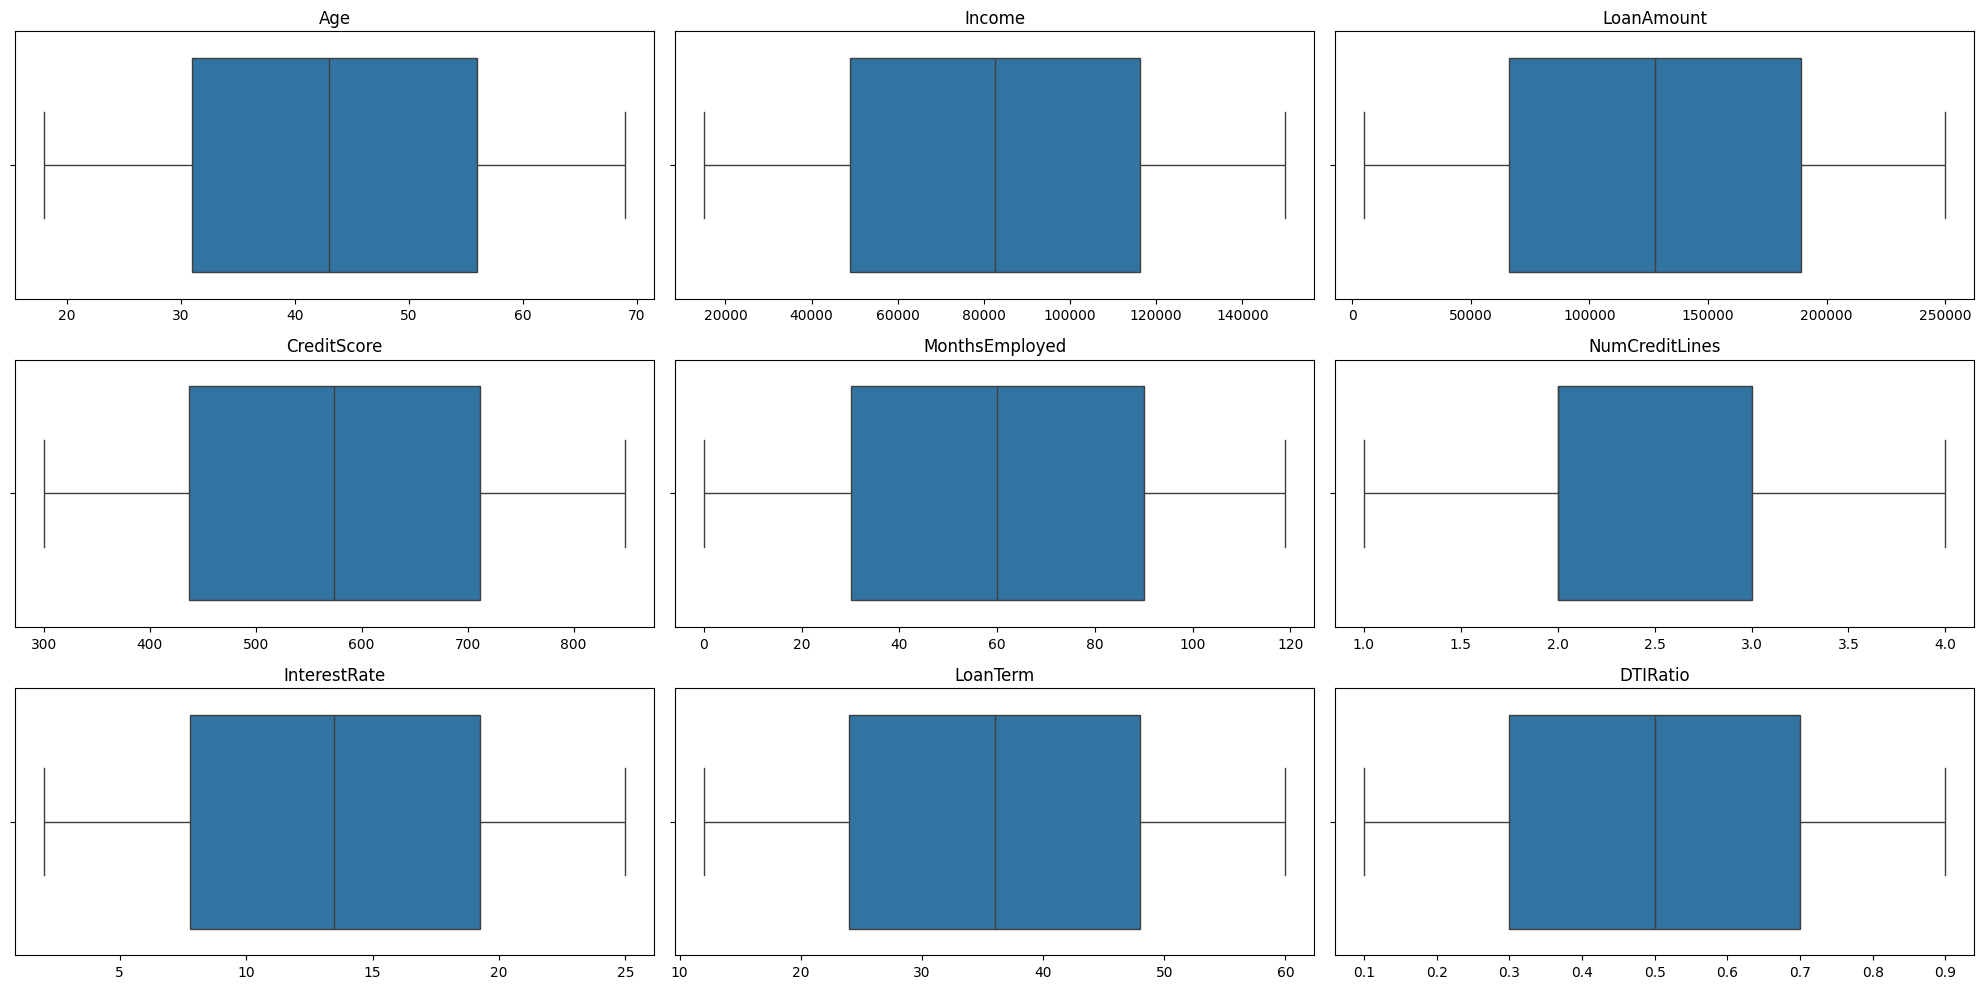

In [ ]:
plt.figure(figsize=(20, 10))
index = 1

for col in numerical_variable.columns:
  if col != 'Default':
    plt.subplot(3, 3, index)
    sns.boxplot(x=df[col])
    plt.title(col)
    index += 1
    plt.xlabel('')

plt.tight_layout()
plt.show()

Based on the provided box plots, we can observe that there are no outliers in any of the variables.

# Exploratory Data Analysis (EDA)

## Checking Distribution Shape

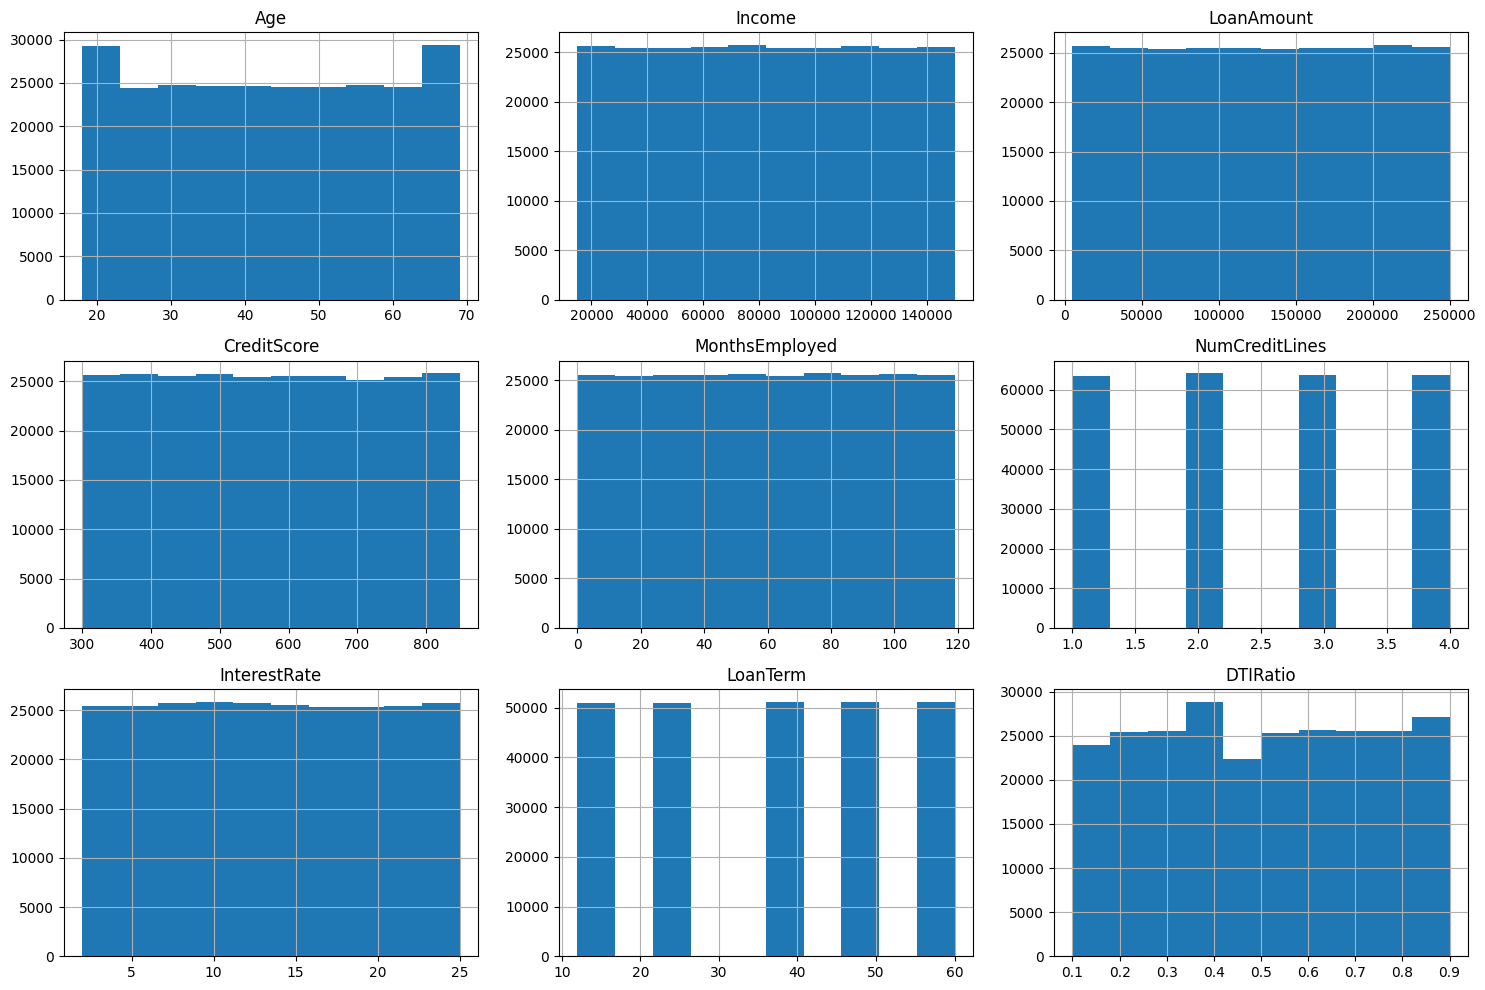

In [ ]:
numerical_variable.drop(columns=['Default']).hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Based on the provided histograms, the distributions of the variables are approximately symmetrical.

In [ ]:
for col in numerical_variable.columns:
  if col != 'Default':
    skewness = df[col].skew()
    print(f"Skewness of {col}: {skewness}")
    print('-'*50)

Skewness of Age: 0.0006978543690462524
--------------------------------------------------
Skewness of Income: -0.00038051328464016167
--------------------------------------------------
Skewness of LoanAmount: -0.0018272468470878597
--------------------------------------------------
Skewness of CreditScore: 0.004688186338493831
--------------------------------------------------
Skewness of MonthsEmployed: -0.0021416836171986807
--------------------------------------------------
Skewness of NumCreditLines: -0.0002780247588620178
--------------------------------------------------
Skewness of InterestRate: 0.004607890923307074
--------------------------------------------------
Skewness of LoanTerm: -0.0021777961669722217
--------------------------------------------------
Skewness of DTIRatio: -0.001498963370252565
--------------------------------------------------


All features exhibit near-zero skewness. The distributions of most of the variables in the dataset are approximately symmetrical.

## Exploring Numerical Variable

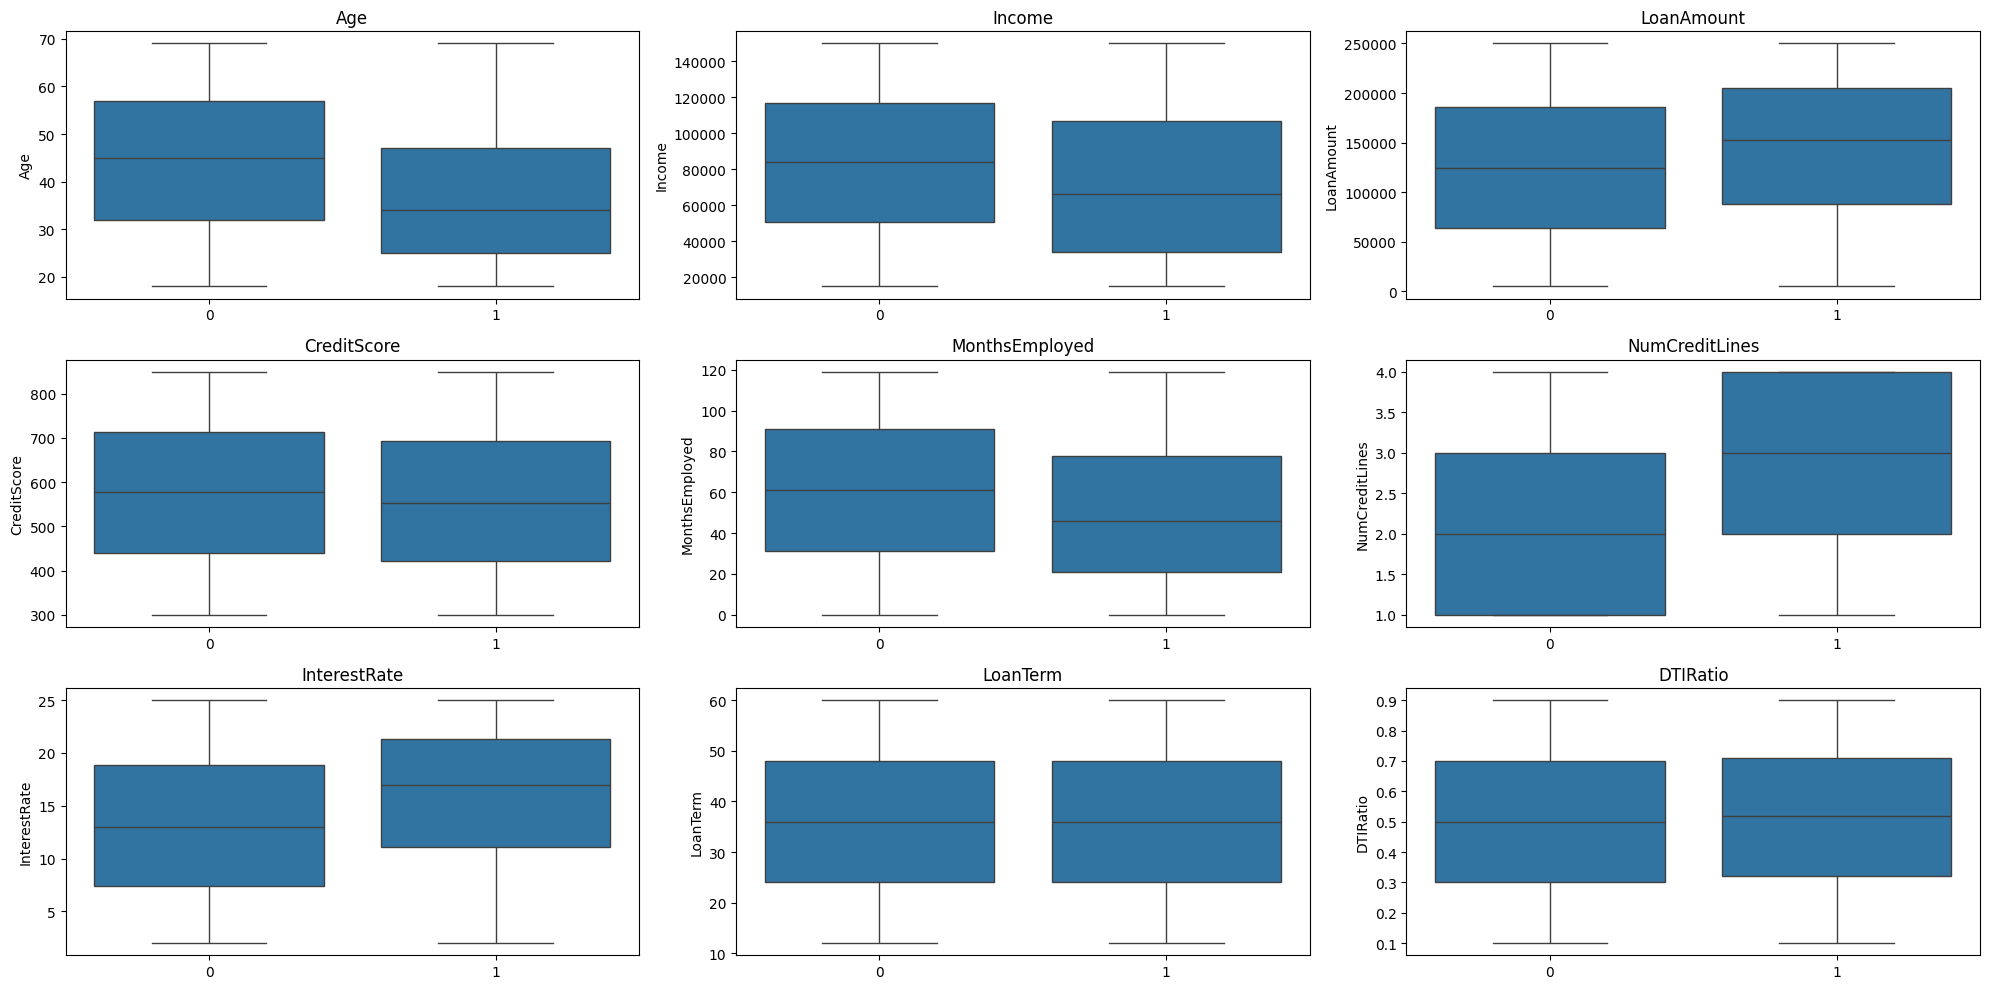

In [ ]:
plt.figure(figsize=(20, 10))
index = 1

for col in numerical_variable.columns:
    if col != 'Default':
        plt.subplot(3, 3, index)
        sns.boxplot(x='Default', y=col, data=df)
        plt.title(col)
        plt.xlabel('')
        index += 1

plt.tight_layout()
plt.show()

In [ ]:
def compute_ci(series, conf_level=0.95):
  mean = series.mean()
  std_err = stats.sem(series)
  lower, upper = stats.norm.interval(conf_level, loc=mean, scale=std_err)
  return f"({lower:.2f}, {upper:.2f})"

In [ ]:
for col in numerical_variable.columns:
  if col != 'Default':
    print(f"For {col}:")
    count_0 = df[col][df['Default'] == 0].count()
    count_1 = df[col][df['Default'] == 1].count()

    mean_0 = round(df[col][df['Default'] == 0].mean(), 2)
    mean_1 = round(df[col][df['Default'] == 1].mean(), 2)

    median_0 = round(df[col][df['Default'] == 0].median(), 2)
    median_1 = round(df[col][df['Default'] == 1].median(), 2)

    mode_0 = round(df[col][df['Default'] == 0].mode().iloc[0], 2)
    mode_1 = round(df[col][df['Default'] == 1].mode().iloc[0], 2)

    std_0 = round(df[col][df['Default'] == 0].std(), 2)
    std_1 = round(df[col][df['Default'] == 1].std(), 2)

    ci_0 = compute_ci(df[col][df['Default'] == 0])
    ci_1 = compute_ci(df[col][df['Default'] == 1])

    stats_dict = {
        "Count": [count_0, count_1],
        "Mean": [mean_0, mean_1],
        "Median": [median_0, median_1],
        "Mode": [mode_0, mode_1],
        "Std Dev": [std_0, std_1],
        "95% CI": [ci_0, ci_1]
    }

    stats_df = pd.DataFrame(stats_dict, index=["Non-Default", "Default"]).T
    print(stats_df)
    print('-'*50)

For Age:
            Non-Default         Default
Count            225694           29653
Mean              44.41           36.56
Median             45.0            34.0
Mode                 65              22
Std Dev           14.89            13.9
95% CI   (44.35, 44.47)  (36.40, 36.72)
--------------------------------------------------
For Income:
                  Non-Default               Default
Count                  225694                 29653
Mean                 83899.17              71844.72
Median                84237.5               66566.0
Mode                    69492                 15293
Std Dev               38498.8               40785.1
95% CI   (83740.33, 84058.00)  (71380.51, 72308.93)
--------------------------------------------------
For LoanAmount:
                    Non-Default                 Default
Count                    225694                   29653
Mean                  125353.66               144515.31
Median                 124236.0                15

## Exploring Categorical Variables

In [ ]:
for col in categorical_variable.columns:
    print(categorical_variable[col].value_counts())
    print('-'*50)

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64
--------------------------------------------------
EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64
--------------------------------------------------
MaritalStatus
Married     85302
Divorced    85033
Single      85012
Name: count, dtype: int64
--------------------------------------------------
HasMortgage
Yes    127677
No     127670
Name: count, dtype: int64
--------------------------------------------------
HasDependents
Yes    127742
No     127605
Name: count, dtype: int64
--------------------------------------------------
LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64
--------------------------------------------------
HasCoSigner
Yes    127701
No     127646
Name: count, dtype: int64
--------------

All of these categorical features appear to be balanced.

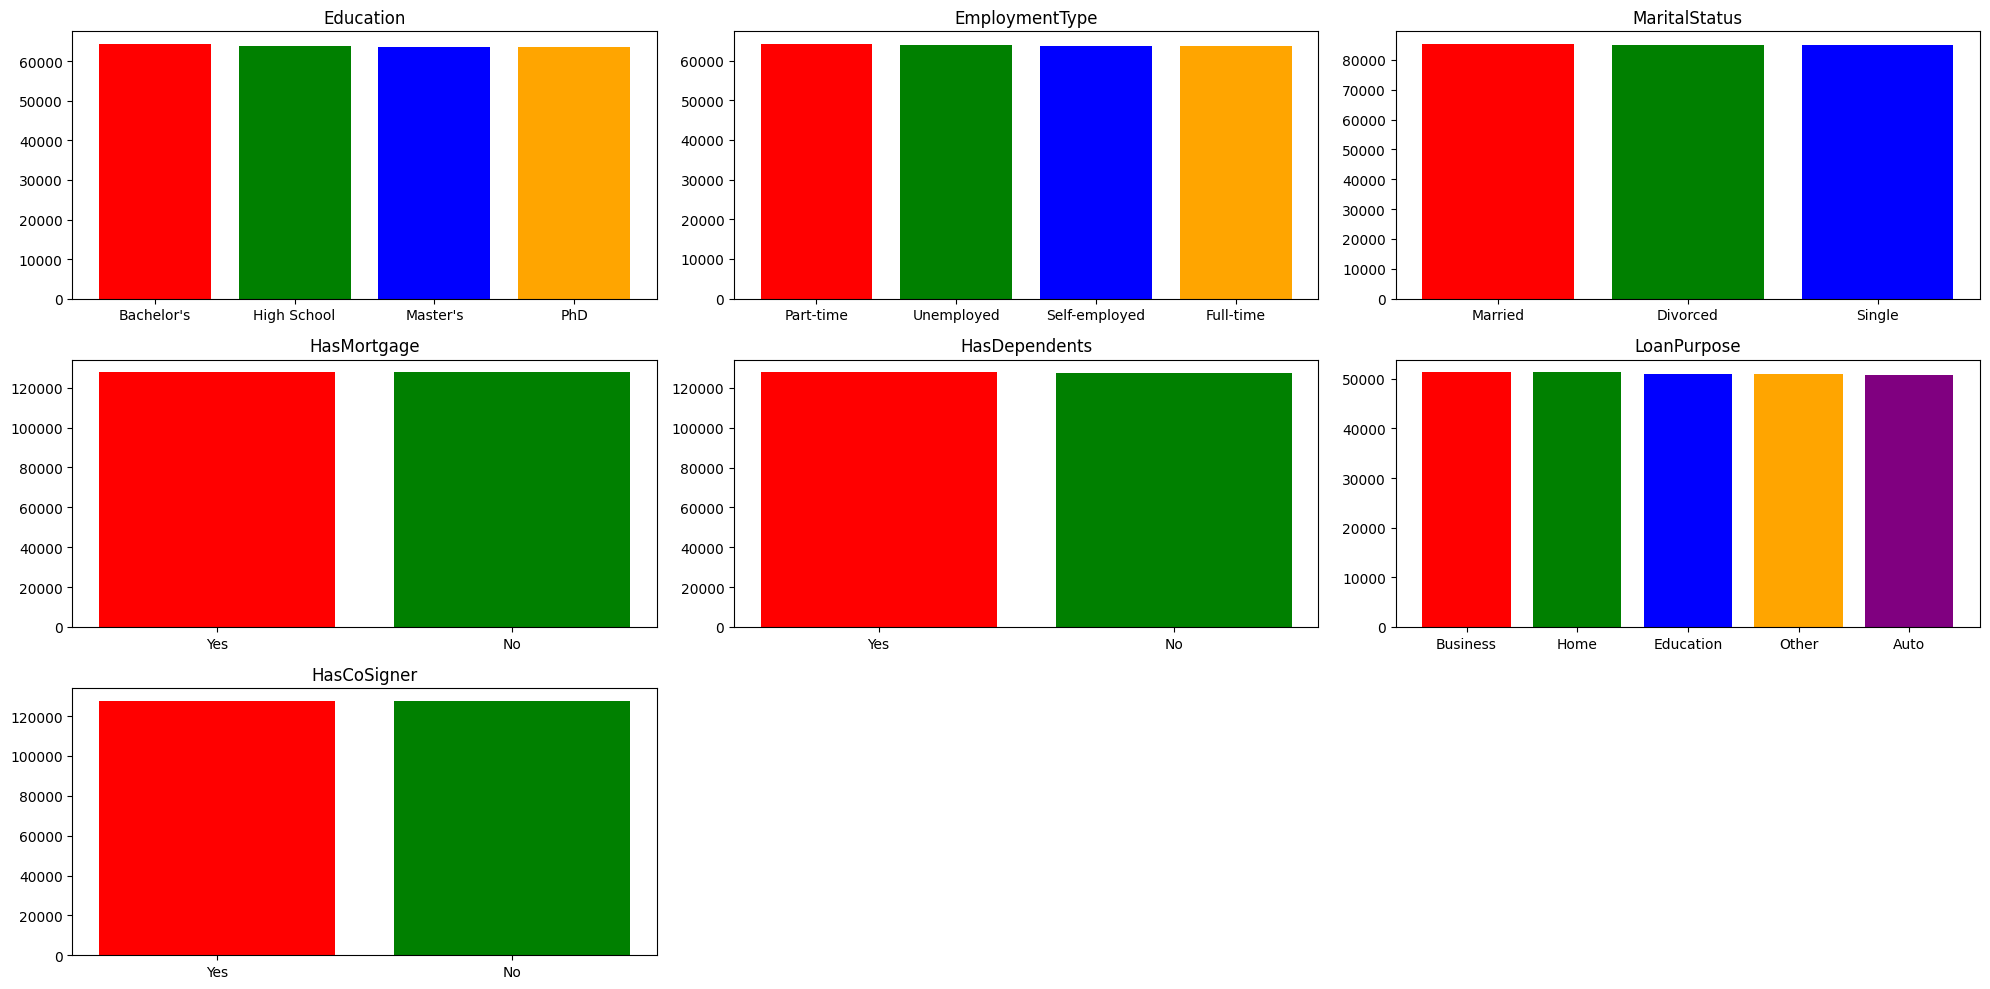

In [ ]:
plt.figure(figsize=(20, 10))
index = 1
color_map = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

for col in categorical_variable.columns:
    if col != 'Default':
        plt.subplot(3, 3, index)
        plt.bar(categorical_variable[col].value_counts().index, categorical_variable[col].value_counts(), color=color_map)
        plt.title(col)
        plt.xlabel('')
        index += 1

plt.tight_layout()
plt.show()

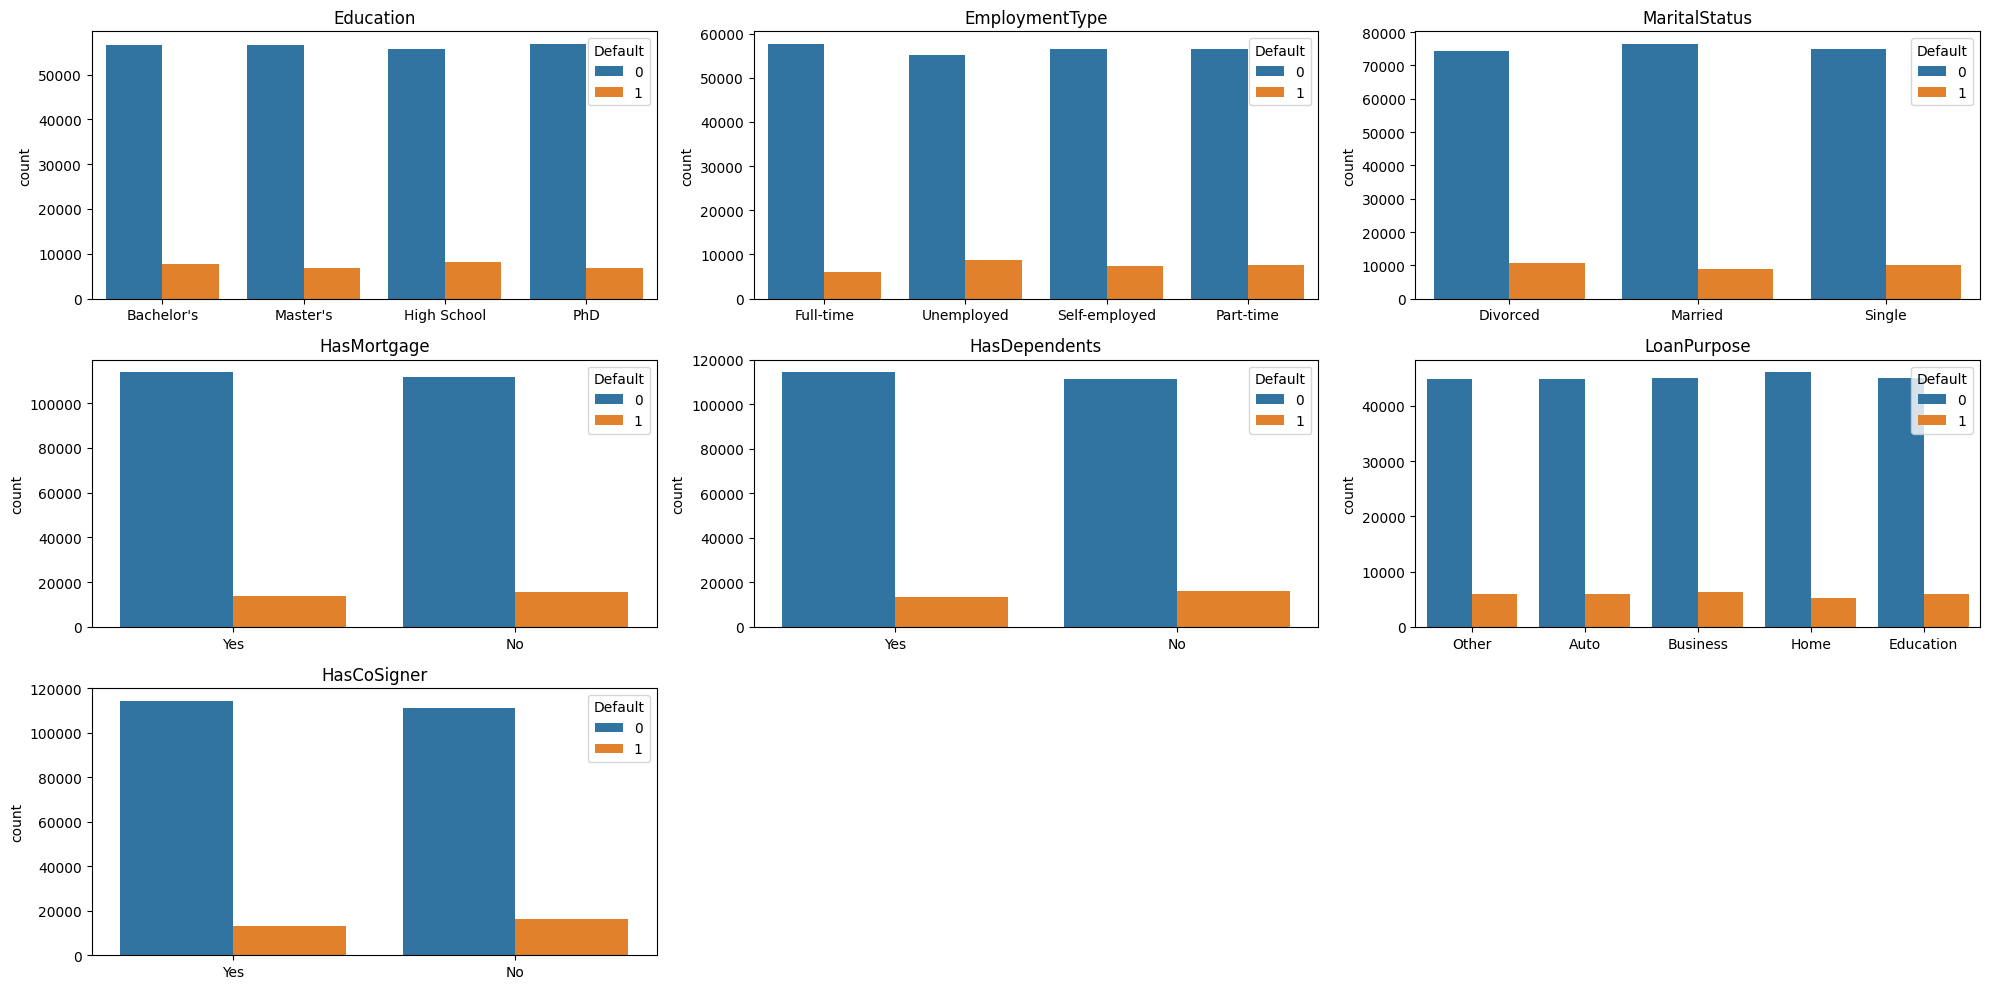

In [ ]:
plt.figure(figsize=(20, 10))
index = 1

for col in categorical_variable.columns:
    if col != 'Default':
        plt.subplot(3, 3, index)
        sns.countplot(x=col, hue='Default', data=df)
        plt.title(col)
        plt.xlabel('')
        index += 1

plt.tight_layout()
plt.show()

## Checking Class Balance

Default Count: 29653
Non-Default Count: 225694
Default Percentage: 11.61%
Non-Default Percentage: 88.39%


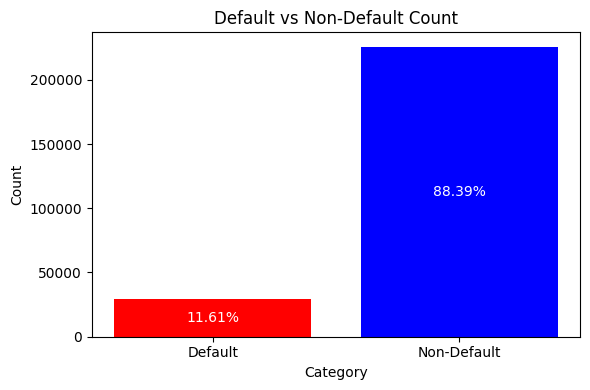

In [ ]:
default_count = df['Default'].sum()
non_default_count = len(df) - default_count

default_percentage = round(default_count / df['Default'].count() * 100, 2)
non_default_percentage = round(non_default_count / df['Default'].count() * 100, 2)

print(f"Default Count: {default_count}")
print(f"Non-Default Count: {non_default_count}")
print(f"Default Percentage: {default_percentage}%")
print(f"Non-Default Percentage: {non_default_percentage}%")

categories = ["Default", "Non-Default"]
counts = [default_count, non_default_count]
percentages = [default_percentage, non_default_percentage]

plt.figure(figsize=(6, 4))
bars = plt.bar(categories, counts, color=['red', 'blue'])

for bar, percentage in zip(bars, percentages):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
           f"{percentage}%", ha='center', va='center', fontsize=10, color='white')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Default vs Non-Default Count")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

The dataset is highly imbalanced with only 11.61% defaults and 88.39% non-defaults. Most of the loans are not defaulted (label = 0) and a smaller percentage of loans defaulted (label = 1).

## Finding Features' Contribution to Default

### Correlation Matrix Heatmap

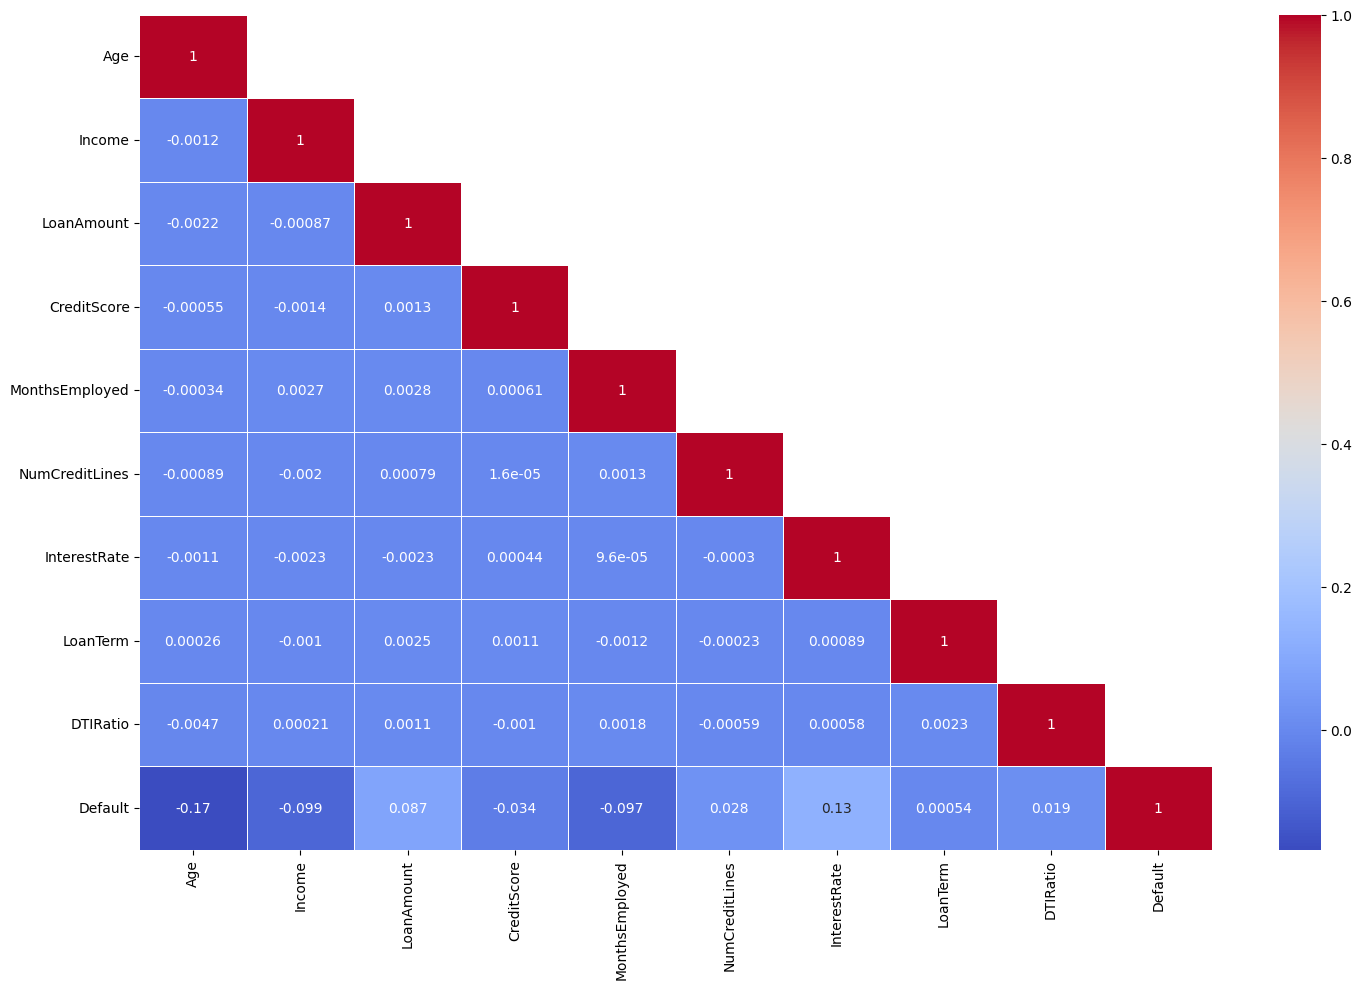

In [ ]:
correlation_matrix = numerical_variable.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.tight_layout()
plt.show()

Pairwise linear relationships between numerical variables are not significant.

**Observation**
* Default and Interest Rate are positively correlated (0.13)
 * As the interest rate increases, the likelihood of loan default increases.
* Default and Loan Amount are positively correlated (0.087)
 * As the loan amount increases, the likelihood of loan default increases.
* Default and Age are negatively correlated (-0.17)
 * As the age increases, the likelihood of loan default decreases.
* Default and Income are negatively correlated (-0.099)
 * As the income increases, the likelihood of loan default decreases.
* Default and Credit Score are negatively correlated (-0.034)
 * As the credit score increases, the likelihood of loan default decreases.
* Default and Months Employed are negatively correlated (-0.097)
 * As the months employed increases, the likelihood of loan default decreases.
* Default and Debt-To-Income Ratio are positively correlated (0.019)
 * As the debt-to-income ratio increases, the likelihood of loan default increases.

### Chi-Square Test

In [ ]:
chi_square_results = {}

for col in categorical_variable.columns:
    contingency_table = pd.crosstab(df[col], df['Default'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    chi_square_results[col] = {'Chi-Square': chi2, 'P-Value': p_value, 'Degrees of Freedom': dof}

for col, results in chi_square_results.items():
    print(f"{col}:")
    print(f"Chi-Square: {results['Chi-Square']}")
    print(f"P-Value: {results['P-Value']}")
    print(f"Degrees of Freedom: {results['Degrees of Freedom']}")
    print('-' * 50)

for col, results in chi_square_results.items():
    if results['P-Value'] < 0.05:
        print(f"{col} is significant (p-value < 0.05).")
    else:
        print(f"{col} is not significant (p-value >= 0.05).")

Education:
Chi-Square: 214.01898255592704
P-Value: 3.9404864175508716e-46
Degrees of Freedom: 3
--------------------------------------------------
EmploymentType:
Chi-Square: 529.7449284156027
P-Value: 1.7066378020433154e-114
Degrees of Freedom: 3
--------------------------------------------------
MaritalStatus:
Chi-Square: 200.3611356065489
P-Value: 3.105504830442356e-44
Degrees of Freedom: 2
--------------------------------------------------
HasMortgage:
Chi-Square: 133.25200560751577
P-Value: 7.96338322455275e-31
Degrees of Freedom: 1
--------------------------------------------------
HasDependents:
Chi-Square: 306.8506093007918
P-Value: 1.0600086119645882e-68
Degrees of Freedom: 1
--------------------------------------------------
LoanPurpose:
Chi-Square: 127.93422475687699
P-Value: 1.0767865809403042e-26
Degrees of Freedom: 4
--------------------------------------------------
HasCoSigner:
Chi-Square: 390.3050463714834
P-Value: 7.103434211754059e-87
Degrees of Freedom: 1
----------

## Checking Multicollinearity with VIF

In [ ]:
vif_feature = numerical_variable.drop(columns=['Default'])
vif_feature = add_constant(vif_feature)

vif_data = pd.DataFrame()
vif_data["Feature"] = vif_feature.columns
vif_data["VIF"] = [variance_inflation_factor(vif_feature.values, i) for i in range(vif_feature.shape[1])]

vif_data

,Feature,VIF
0,const,51.593006
1,Age,1.000031
2,Income,1.000022
3,LoanAmount,1.000029
4,CreditScore,1.000007
5,MonthsEmployed,1.000022
6,NumCreditLines,1.000008
7,InterestRate,1.000013
8,LoanTerm,1.000016
9,DTIRatio,1.000033


All variables have VIF values close to 1. This means that none of the variables is highly correlated with others.

# Feature Engineering

In [ ]:
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['Income']

df['StabilityScore'] = (df['MonthsEmployed'] / 12) / df['LoanTerm']

In [ ]:
categorical_variables_engineered = df.select_dtypes(include=['object']).drop(columns=['LoanID'])
numerical_variable_engineered = df.select_dtypes(include=['int64', 'float64'])

print("Categorical Variables (Engineered):")
print(categorical_variables_engineered.columns)
print("\nNumerical Variables (Engineered):")
print(numerical_variable_engineered.columns)

Categorical Variables (Engineered):
Index(['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'],
      dtype='object')

Numerical Variables (Engineered):
Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default',
       'LoanToIncomeRatio', 'StabilityScore'],
      dtype='object')


#Engineered Features Correlation

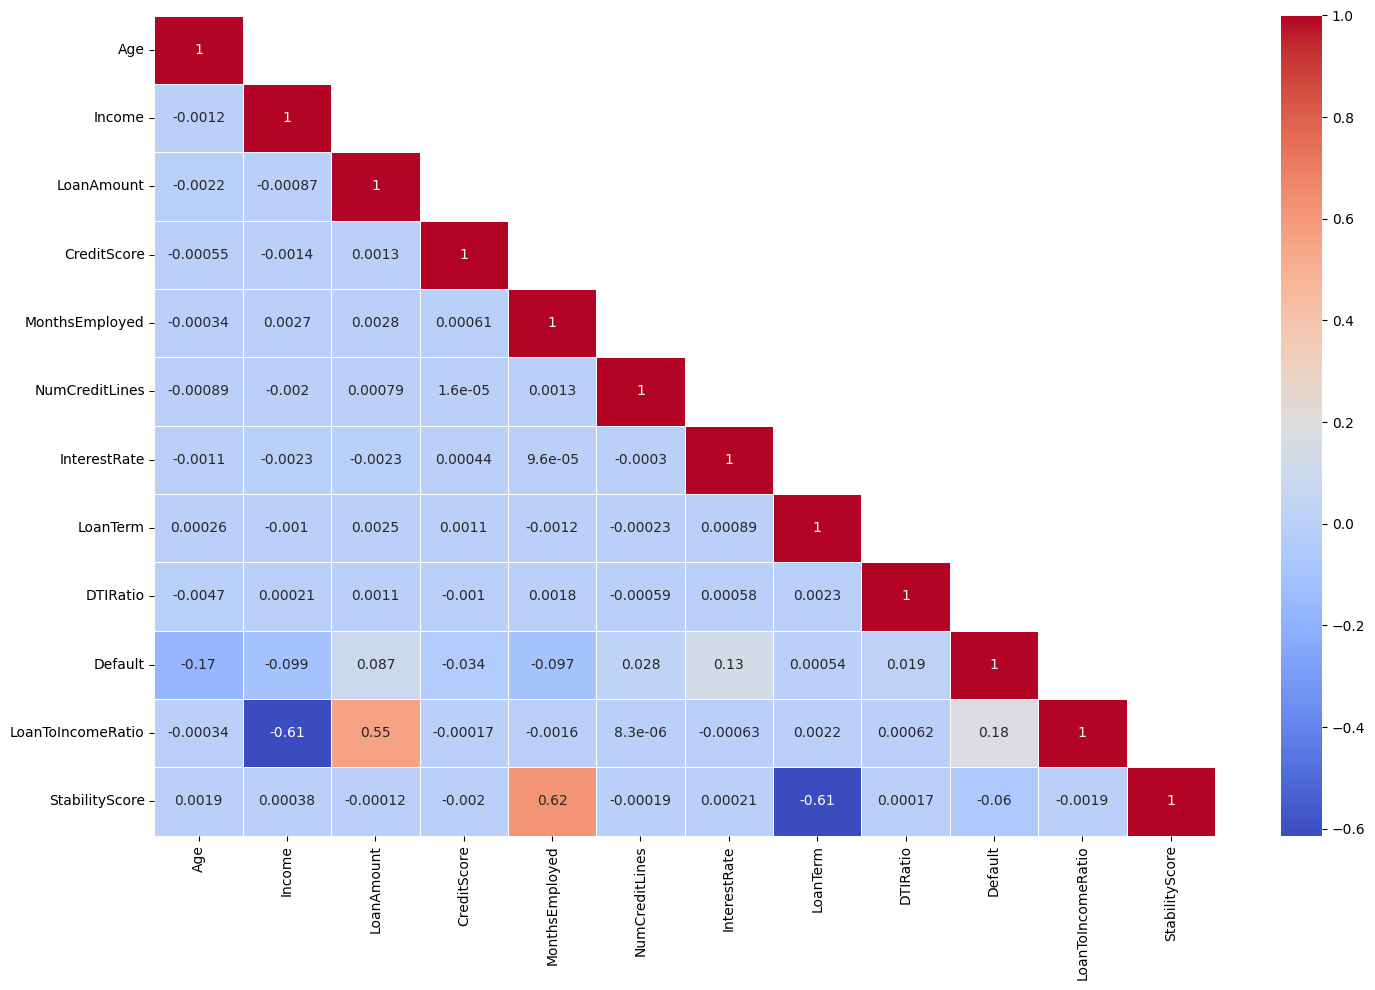

In [ ]:
correlation_matrix_engineered = numerical_variable_engineered.corr()

mask = np.triu(np.ones_like(correlation_matrix_engineered, dtype=bool), k=1)

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_engineered, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.tight_layout()
plt.show()

# Engineered Features Multicollinearity

In [ ]:
vif_feature_engineered = numerical_variable_engineered.drop(columns=['Default'])
vif_feature_engineered = add_constant(vif_feature_engineered)

vif_data_engineered = pd.DataFrame()
vif_data_engineered["Feature"] = vif_feature_engineered.columns
vif_data_engineered["VIF"] = [variance_inflation_factor(vif_feature_engineered.values, i) for i in range(vif_feature_engineered.shape[1])]

vif_data_engineered

,Feature,VIF
0,const,64.047136
1,Age,1.000052
2,Income,2.186609
3,LoanAmount,1.970152
4,CreditScore,1.000028
5,MonthsEmployed,2.595636
6,NumCreditLines,1.000022
7,InterestRate,1.000017
8,LoanTerm,2.543715
9,DTIRatio,1.000034


# Encoding Categorical Features
Since our dataset contains categorical variables, we need to convert them into numerical format using encoding techniques.

In [ ]:
# RANK-BASED ENCODING
education_mapping = {
    'High School': 1,
    'Bachelor\'s': 2,
    'Master\'s': 3,
    'PhD': 4
}
df['Education'] = df['Education'].map(education_mapping)

# BINARY ENCODING
df['HasMortgage'] = df['HasMortgage'].apply(lambda x: 1 if x == 'Yes' else 0)
df['HasDependents'] = df['HasDependents'].apply(lambda x: 1 if x == 'Yes' else 0)
df['HasCoSigner'] = df['HasCoSigner'].apply(lambda x: 1 if x == 'Yes' else 0)

# ONE HOT ENCODING
df = pd.get_dummies(df, columns=['EmploymentType'], prefix='EmploymentType', drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['MaritalStatus'], prefix='MaritalStatus', drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['LoanPurpose'], prefix='LoanPurpose', drop_first=True, dtype=int)

In [ ]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,HasMortgage,HasDependents,HasCoSigner,Default,LoanToIncomeRatio,StabilityScore,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,2,1,1,1,0,0.588262,0.185185,0,0,0,0,0,0,0,0,1
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,3,0,0,1,0,2.467481,0.020833,0,0,0,1,0,0,0,0,1
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,3,1,1,0,1,1.534154,0.090278,0,0,1,0,0,0,0,0,0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,1,0,0,0,0,1.412638,0.000000,0,0,0,1,0,1,0,0,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,2,0,1,0,0,0.447179,0.013889,0,0,1,0,0,0,0,0,0


# Splitting Data into Train and Test Sets

In [ ]:
X = df.drop(columns=['Default', 'LoanID'])
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Importance

                         Feature  Importance
13             LoanToIncomeRatio    0.104708
6                   InterestRate    0.104548
1                         Income    0.093694
0                            Age    0.090637
2                     LoanAmount    0.087788
3                    CreditScore    0.083559
14                StabilityScore    0.076203
4                 MonthsEmployed    0.075446
8                       DTIRatio    0.073460
7                       LoanTerm    0.028370
5                 NumCreditLines    0.027322
9                      Education    0.026715
10                   HasMortgage    0.012731
19          MaritalStatus_Single    0.012059
11                 HasDependents    0.010964
18         MaritalStatus_Married    0.010958
12                   HasCoSigner    0.010691
20          LoanPurpose_Business    0.010485
15      EmploymentType_Part-time    0.010353
16  EmploymentType_Self-employed    0.010343
23             LoanPurpose_Other    0.010327
21        

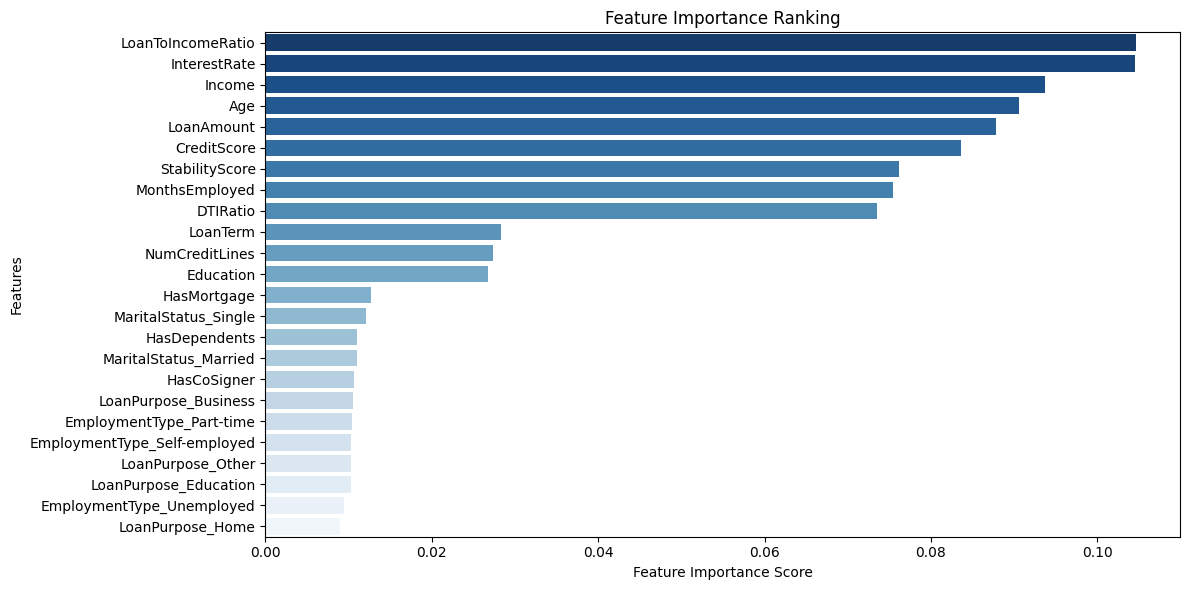

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='Blues_r', legend=False)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.tight_layout()
plt.show()

# Scaling and Standardizing Features

In [ ]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
       'LoanToIncomeRatio', 'StabilityScore']

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

# Handling Class Imbalance with SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Models Evaluation and Prediction

Logistic Regression
Accuracy: 0.7387
Precision: 0.2292
Recall: 0.5289
F1-Score: 0.3198
ROC AUC: 0.7145
PR AUC: 0.2579
--------------------------------------------------


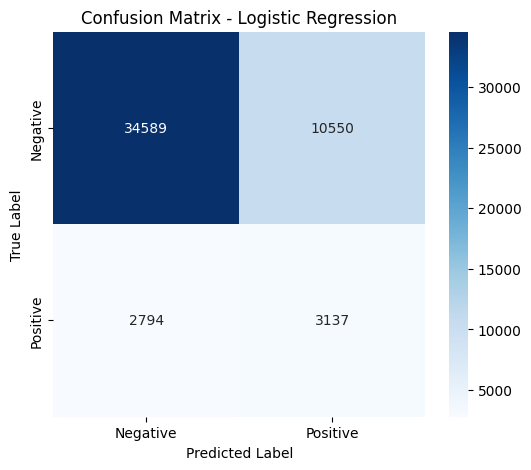

--------------------------------------------------
Random Forest
Accuracy: 0.8421
Precision: 0.3128
Recall: 0.3003
F1-Score: 0.3064
ROC AUC: 0.7273
PR AUC: 0.2639
--------------------------------------------------


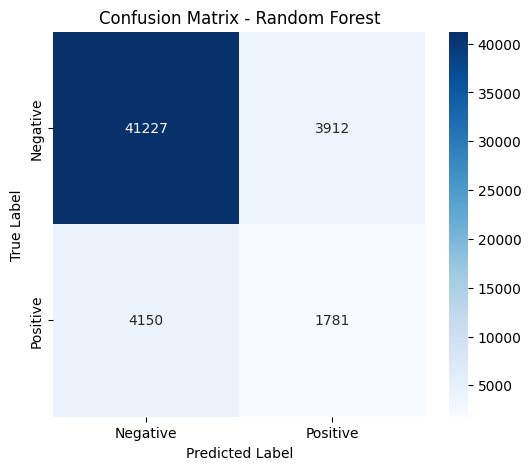

--------------------------------------------------
Naive Bayes
Accuracy: 0.7627
Precision: 0.2443
Recall: 0.4984
F1-Score: 0.3278
ROC AUC: 0.7143
PR AUC: 0.2703
--------------------------------------------------


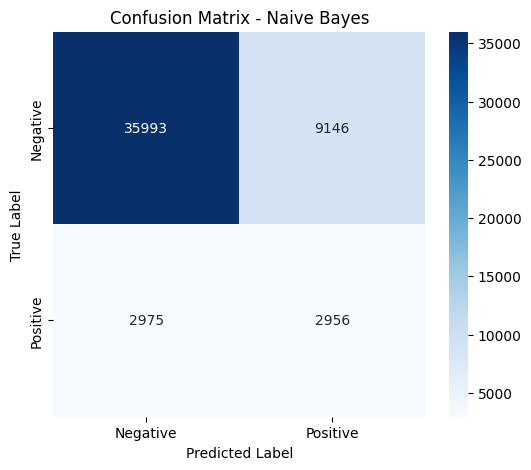

--------------------------------------------------
XGBoost
Accuracy: 0.8643
Precision: 0.3470
Recall: 0.1914
F1-Score: 0.2467
ROC AUC: 0.7152
PR AUC: 0.2614
--------------------------------------------------


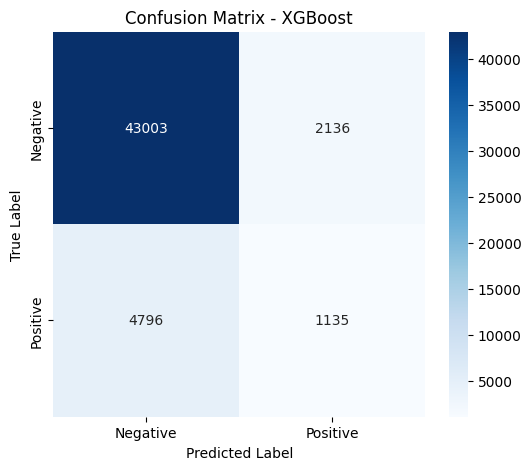

--------------------------------------------------


In [ ]:
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "ROC AUC": [],
    "PR AUC": []
}

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42),
}

for model_name, model in models.items():
    print(f"{model_name}")

    # Train model
    model.fit(X_train_resampled, y_train_resampled)
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print('-'*50)

    # Store in results dictionary
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)
    results["ROC AUC"].append(roc_auc)
    results["PR AUC"].append(pr_auc)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    print('-'*50)

In [ ]:
models = results["Model"]
model_accuracy = results["Accuracy"]
model_precision = results["Precision"]
model_recall = results["Recall"]
model_f1_score = results["F1-Score"]
model_roc_auc = results["ROC AUC"]
model_pr_auc = results["PR AUC"]

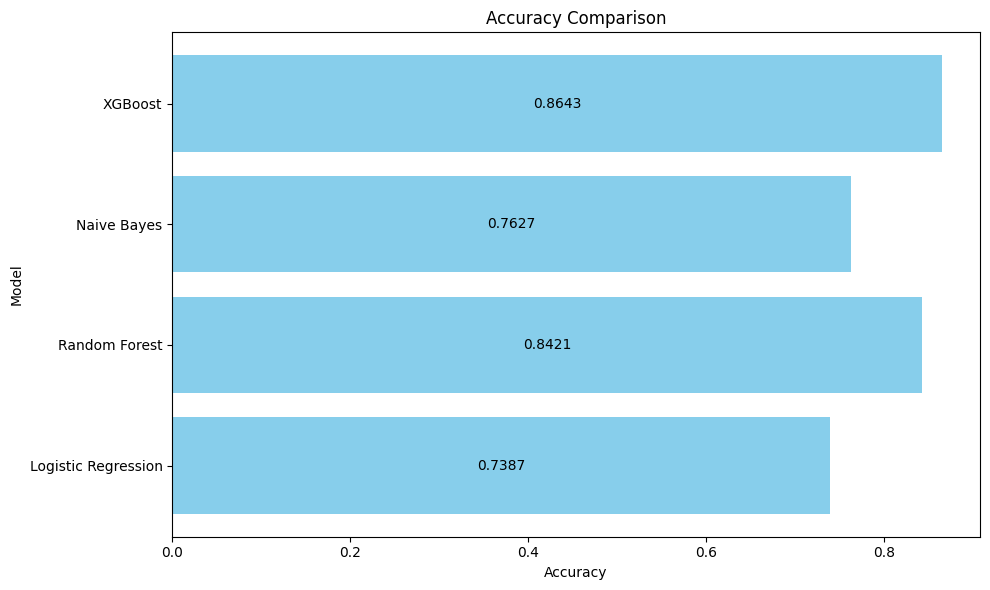

In [ ]:
# Accuracy Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_accuracy, color='skyblue')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')

for index, value in enumerate(model_accuracy):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

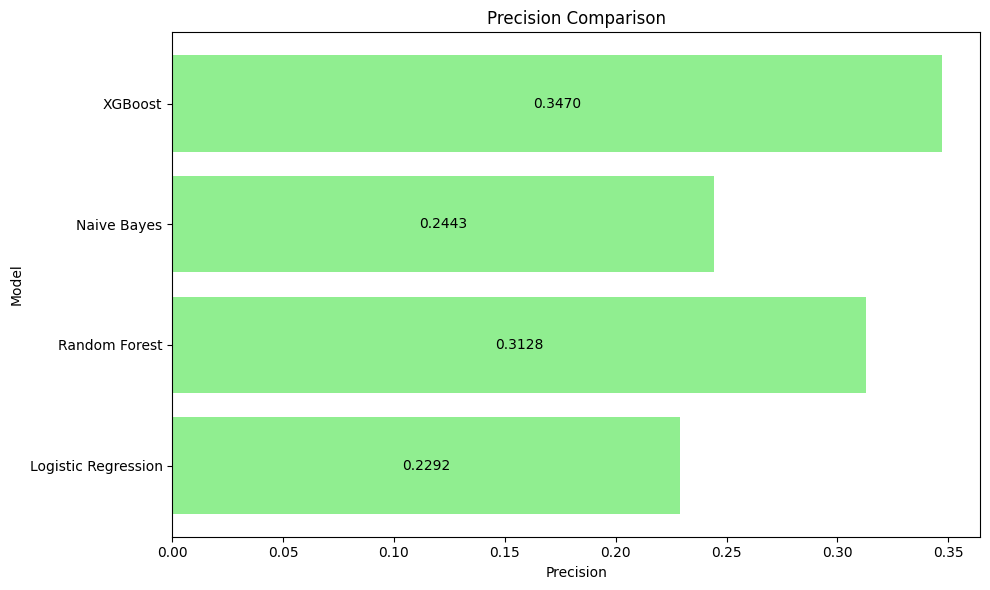

In [ ]:
# Precision Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_precision, color='lightgreen')
plt.title('Precision Comparison')
plt.xlabel('Precision')
plt.ylabel('Model')

for index, value in enumerate(model_precision):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

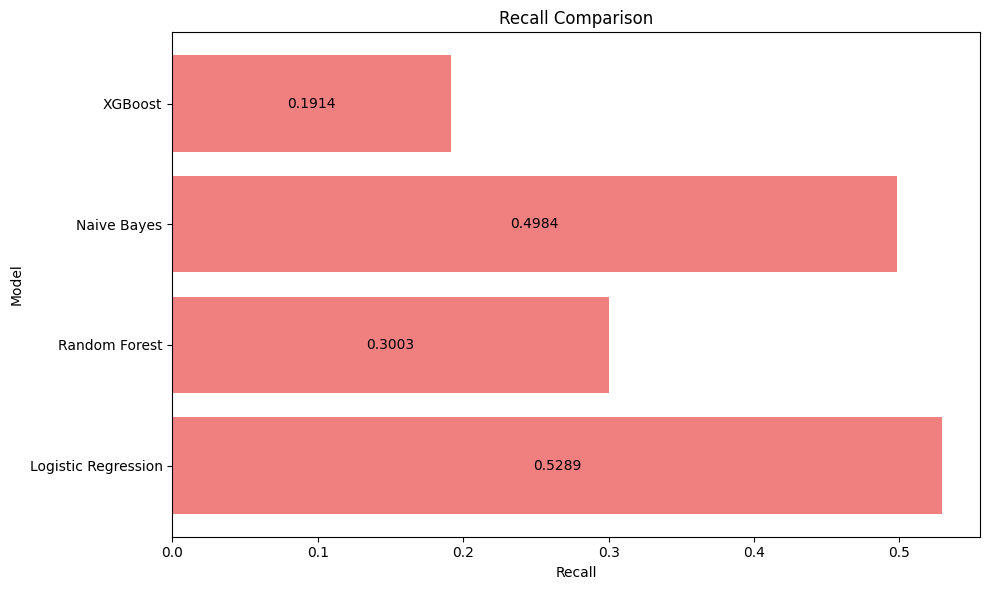

In [ ]:
# Recall Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_recall, color='lightcoral')
plt.title('Recall Comparison')
plt.xlabel('Recall')
plt.ylabel('Model')

for index, value in enumerate(model_recall):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

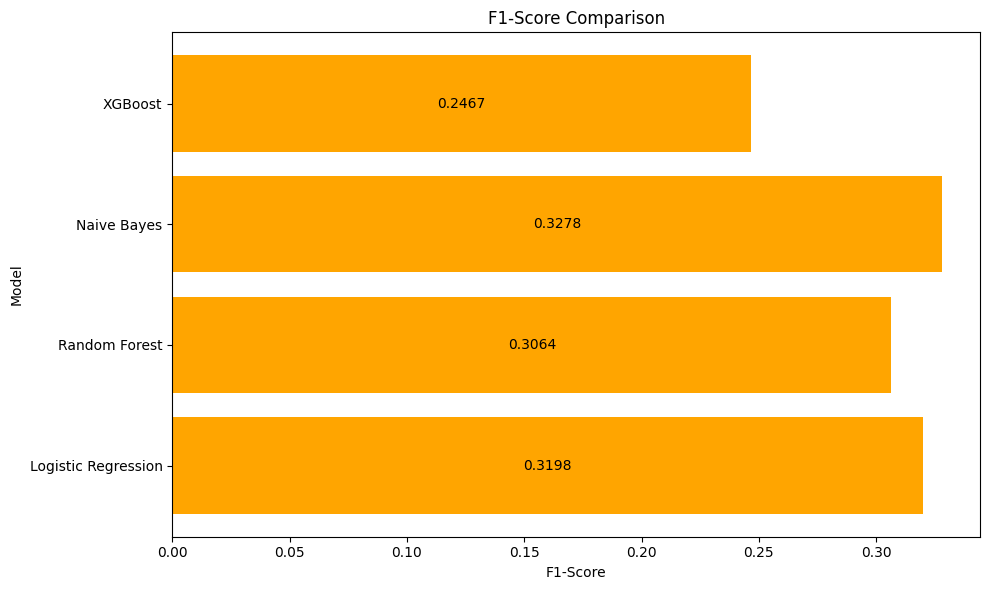

In [ ]:
# F1-Score Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_f1_score, color='orange')
plt.title('F1-Score Comparison')
plt.xlabel('F1-Score')
plt.ylabel('Model')

for index, value in enumerate(model_f1_score):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

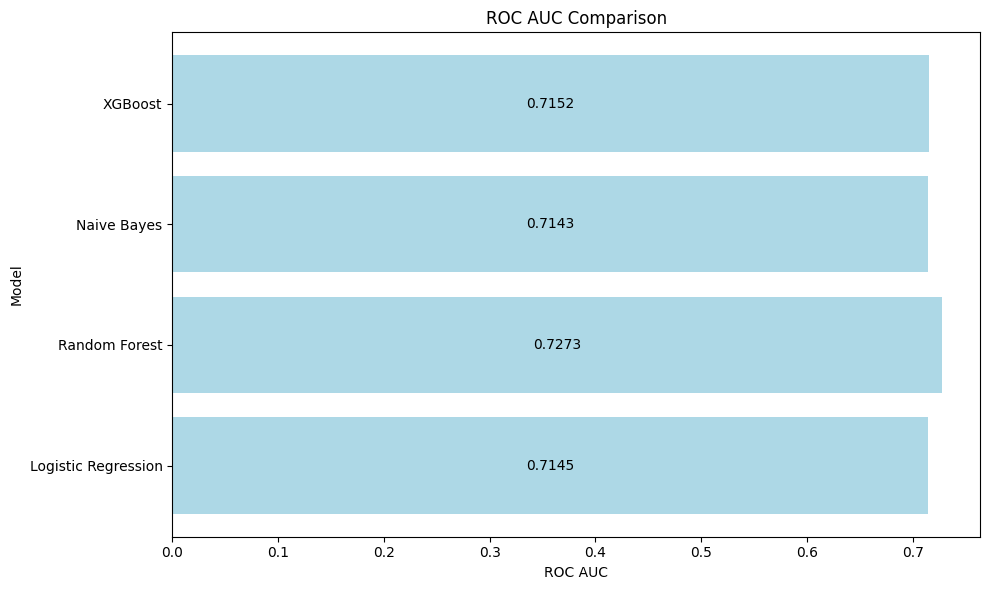

In [ ]:
# ROC AUC Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_roc_auc, color='lightblue')
plt.title('ROC AUC Comparison')
plt.xlabel('ROC AUC')
plt.ylabel('Model')

for index, value in enumerate(model_roc_auc):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

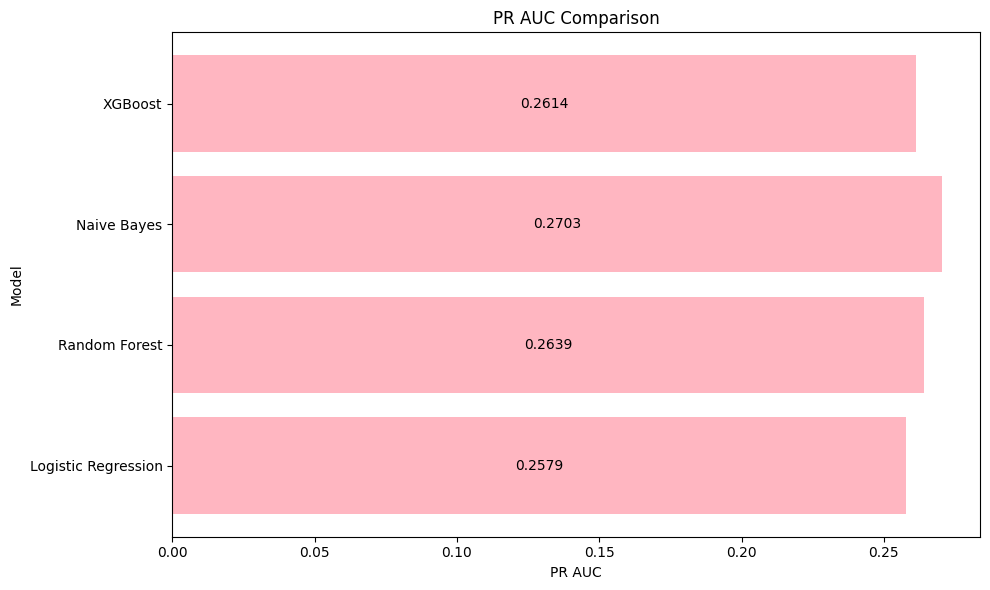

In [ ]:
# PR AUC Bar Graph
plt.figure(figsize=(10, 6))
plt.barh(models, model_pr_auc, color='lightpink')
plt.title('PR AUC Comparison')
plt.xlabel('PR AUC')
plt.ylabel('Model')

for index, value in enumerate(model_pr_auc):
    plt.text(value / 2, index, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

## Logistic Regression

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.3 MB/s eta 0:00:00


In [ ]:
import optuna

[I 2025-04-05 13:15:04,834] A new study created in memory with name: no-name-08e5ac25-628e-4ea8-9420-f5d7c861c0b2
[I 2025-04-05 13:15:17,289] Trial 0 finished with value: 0.2580057222272105 and parameters: {'C': 270.16842618119057, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.2580057222272105.
[I 2025-04-05 13:15:24,874] Trial 1 finished with value: 0.2579780074621425 and parameters: {'C': 542.1022772325645, 'penalty': 'l1', 'solver': 'saga', 'class_weight': None}. Best is trial 0 with value: 0.2580057222272105.
[I 2025-04-05 13:15:31,073] Trial 2 finished with value: 0.2580058707984152 and parameters: {'C': 787.6672274276698, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 2 with value: 0.2580058707984152.
[I 2025-04-05 13:15:37,737] Trial 4 finished with value: 0.2579852361294796 and parameters: {'C': 889.3932967954656, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 2 with

Best Parameters for Logistic Regression:
{'C': 11.660928208995841, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}
Accuracy: 0.7389
Precision: 0.2295
Recall: 0.5294
F1-Score: 0.3202
ROC AUC: 0.7146
PR AUC: 0.2580
--------------------------------------------------


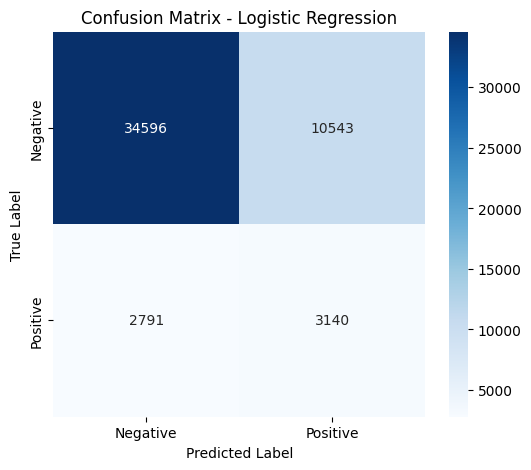

In [ ]:
def objective_logistic_regression(trial):
  C = trial.suggest_float('C', 0.001, 1000)
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

  log_reg = LogisticRegression(
      C=C,
      penalty=penalty,
      solver=solver,
      class_weight=class_weight,
      random_state=42
  )

  log_reg.fit(X_train_resampled, y_train_resampled)
  y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

  pr_auc = average_precision_score(y_test, y_pred_proba)

  return pr_auc

study_log_reg = optuna.create_study(direction='maximize')
study_log_reg.optimize(objective_logistic_regression, n_trials=100, n_jobs=-1)

best_params_log_reg = study_log_reg.best_params
print("Best Parameters for Logistic Regression:")
print(best_params_log_reg)

best_model_log_reg = LogisticRegression(
    **best_params_log_reg,
    random_state=42
)

best_model_log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_log_reg = best_model_log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = best_model_log_reg.predict_proba(X_test_scaled)[:, 1]

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, pos_label=1)
recall_log_reg = recall_score(y_test, y_pred_log_reg, pos_label=1)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label=1)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
pr_auc_log_reg = average_precision_score(y_test, y_pred_proba_log_reg)

print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1-Score: {f1_log_reg:.4f}")
print(f"ROC AUC: {roc_auc_log_reg:.4f}")
print(f"PR AUC: {pr_auc_log_reg:.4f}")
print('-'*50)

cm = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

## Random Forest

[I 2025-04-05 13:23:02,318] A new study created in memory with name: no-name-9f012803-78de-449b-90fb-7c00bd8d7c46
[I 2025-04-05 13:23:15,923] Trial 1 finished with value: 0.23496742112622693 and parameters: {'n_estimators': 12, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.23496742112622693.
[I 2025-04-05 13:24:14,061] Trial 2 finished with value: 0.27356411236624084 and parameters: {'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': None}. Best is trial 2 with value: 0.27356411236624084.
[I 2025-04-05 13:25:17,838] Trial 3 finished with value: 0.2731665192349101 and parameters: {'n_estimators': 25, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.27356411236624084.
[I 2025-04-05 13:26:36,001] Trial 4 finished with val

Best Parameters for Random Forest:
{'n_estimators': 134, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced'}
Accuracy: 0.7368
Precision: 0.2363
Recall: 0.5674
F1-Score: 0.3337
ROC AUC: 0.7387
PR AUC: 0.2931
--------------------------------------------------


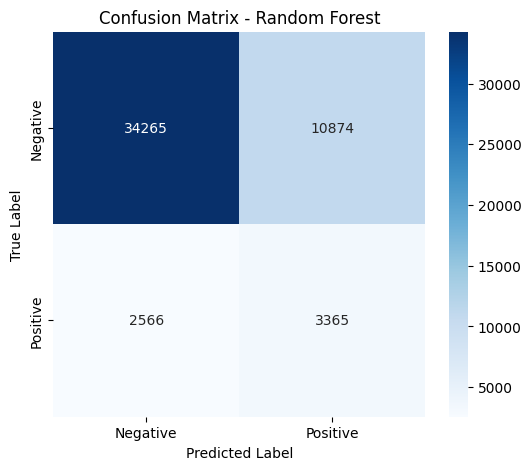

In [ ]:
def objective_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42
    )

    rf.fit(X_train_resampled, y_train_resampled)
    y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

    pr_auc = average_precision_score(y_test, y_pred_proba)

    return pr_auc

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_random_forest, n_trials=100, n_jobs=-1)

best_params_rf = study_rf.best_params
print("Best Parameters for Random Forest:")
print(best_params_rf)

best_model_rf = RandomForestClassifier(
    **best_params_rf,
    random_state=42
)

best_model_rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = best_model_rf.predict(X_test_scaled)
y_pred_proba_rf = best_model_rf.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
pr_auc_rf = average_precision_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print(f"PR AUC: {pr_auc_rf:.4f}")
print('-'*50)

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## Naive Bayes

[I 2025-04-06 05:27:48,123] A new study created in memory with name: no-name-993f5661-5243-4467-a509-fd709235310f
[I 2025-04-06 05:27:48,593] Trial 1 finished with value: 0.27915519232703956 and parameters: {'var_smoothing': 0.03852040303466698}. Best is trial 1 with value: 0.27915519232703956.
[I 2025-04-06 05:27:48,653] Trial 0 finished with value: 0.27703053201804073 and parameters: {'var_smoothing': 0.024787135453552833}. Best is trial 1 with value: 0.27915519232703956.
[I 2025-04-06 05:27:49,108] Trial 3 finished with value: 0.28276682652341056 and parameters: {'var_smoothing': 0.08233608955328248}. Best is trial 3 with value: 0.28276682652341056.
[I 2025-04-06 05:27:49,173] Trial 2 finished with value: 0.2782153270440907 and parameters: {'var_smoothing': 0.031720239211298344}. Best is trial 3 with value: 0.28276682652341056.
[I 2025-04-06 05:27:49,666] Trial 4 finished with value: 0.28042569823035635 and parameters: {'var_smoothing': 0.049995866884645204}. Best is trial 3 with va

Best Parameters for Naive Bayes:
{'var_smoothing': 0.0999785808345551}
Accuracy: 0.6886
Precision: 0.2184
Recall: 0.6520
F1-Score: 0.3272
ROC AUC: 0.7327
PR AUC: 0.2836
--------------------------------------------------


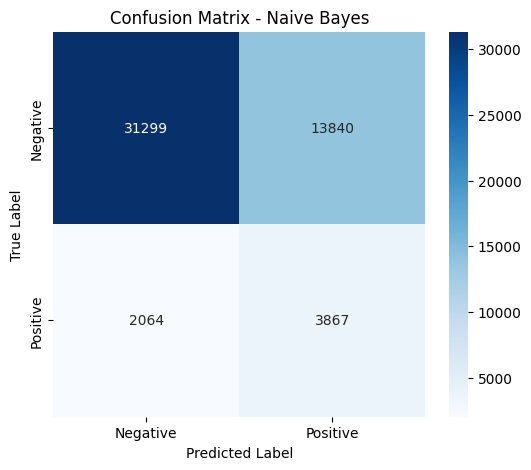

In [ ]:
def objective_naive_bayes(trial):
  var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1)

  nb = GaussianNB(var_smoothing=var_smoothing)

  nb.fit(X_train_resampled, y_train_resampled)
  y_pred_proba = nb.predict_proba(X_test_scaled)[:, 1]

  pr_auc = average_precision_score(y_test, y_pred_proba)

  return pr_auc

study_nb = optuna.create_study(direction='maximize')
study_nb.optimize(objective_naive_bayes, n_trials=100, n_jobs=-1)

best_params_nb = study_nb.best_params
print("Best Parameters for Naive Bayes:")
print(best_params_nb)

best_model_nb = GaussianNB(**best_params_nb)

best_model_nb.fit(X_train_resampled, y_train_resampled)

y_pred_nb = best_model_nb.predict(X_test_scaled)
y_pred_proba_nb = best_model_nb.predict_proba(X_test_scaled)[:, 1]

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, pos_label=1)
recall_nb = recall_score(y_test, y_pred_nb, pos_label=1)
f1_nb = f1_score(y_test, y_pred_nb, pos_label=1)
roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb)
pr_auc_nb = average_precision_score(y_test, y_pred_proba_nb)

print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_nb:.4f}")
print(f"ROC AUC: {roc_auc_nb:.4f}")
print(f"PR AUC: {pr_auc_nb:.4f}")
print('-'*50)

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

## XGBoost

[I 2025-04-06 04:55:55,476] A new study created in memory with name: no-name-9335b650-ecf9-465b-a4a0-a16f1727b1c6
[I 2025-04-06 04:56:16,022] Trial 0 finished with value: 0.2723447560775467 and parameters: {'learning_rate': 0.022654905180253992, 'max_depth': 5, 'n_estimators': 223, 'subsample': 0.6809232290487546, 'colsample_bytree': 0.8921744080478867, 'gamma': 7.400619673209899, 'reg_alpha': 0.0370669900138567, 'reg_lambda': 0.01340326829661116}. Best is trial 0 with value: 0.2723447560775467.
[I 2025-04-06 04:56:32,745] Trial 1 finished with value: 0.23829240332664015 and parameters: {'learning_rate': 0.3995782201344814, 'max_depth': 10, 'n_estimators': 266, 'subsample': 0.7685899112389384, 'colsample_bytree': 0.6284001305980867, 'gamma': 0.39027230862597073, 'reg_alpha': 9.338071908293635e-07, 'reg_lambda': 4.2543261651230155e-07}. Best is trial 0 with value: 0.2723447560775467.
[I 2025-04-06 04:56:46,258] Trial 2 finished with value: 0.2820728550537746 and parameters: {'learning_r

Best Parameters for XGBoost:
{'learning_rate': 0.0012695384127628462, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.6083773892852763, 'colsample_bytree': 0.6416435946535767, 'gamma': 0.7807367737835038, 'reg_alpha': 0.02122048041657504, 'reg_lambda': 0.0006134665485204454}
Accuracy: 0.7422
Precision: 0.2391
Recall: 0.5588
F1-Score: 0.3349
ROC AUC: 0.7353
PR AUC: 0.2923
--------------------------------------------------


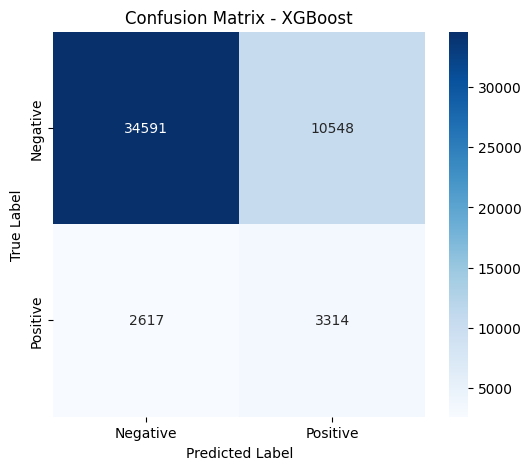

In [ ]:
def objective_xgb(trial):
  learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True)
  max_depth = trial.suggest_int('max_depth', 3, 10)
  n_estimators = trial.suggest_int('n_estimators', 50, 500)
  subsample = trial.suggest_float('subsample', 0.6, 1)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1)
  gamma = trial.suggest_float('gamma', 0, 10)
  reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
  reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)

  xgb = XGBClassifier(
      learning_rate=learning_rate,
      max_depth=max_depth,
      n_estimators=n_estimators,
      subsample=subsample,
      colsample_bytree=colsample_bytree,
      gamma=gamma,
      reg_alpha=reg_alpha,
      reg_lambda=reg_lambda,
      random_state=42
  )

  xgb.fit(X_train_resampled, y_train_resampled)
  y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]

  pr_auc = average_precision_score(y_test, y_pred_proba)

  return pr_auc

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1)

best_params_xgb = study_xgb.best_params
print("Best Parameters for XGBoost:")
print(best_params_xgb)

best_model_xgb = XGBClassifier(
    **best_params_xgb,
    random_state=42
)

best_model_xgb.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = best_model_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print(f"PR AUC: {pr_auc_xgb:.4f}")
print('-'*50)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Model Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

Accuracy: 0.7372
Precision: 0.2355
Recall: 0.5621
F1-Score: 0.3319
ROC AUC: 0.7351
PR AUC: 0.2872
--------------------------------------------------


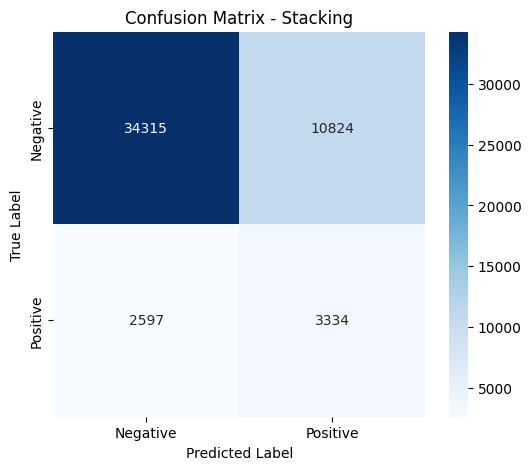

In [ ]:
best_rf = RandomForestClassifier(
    n_estimators=134,
    max_depth=10,
    min_samples_split=3,
    min_samples_leaf=9,
    max_features='log2',
    class_weight='balanced',
    random_state=42
)

best_xgb = XGBClassifier(
    learning_rate=0.0012695384127628462,
    max_depth=9,
    n_estimators=50,
    subsample=0.6083773892852763,
    colsample_bytree=0.6416435946535767,
    gamma=0.7807367737835038,
    reg_alpha=0.02122048041657504,
    reg_lambda=0.0006134665485204454,
    random_state=42
)

best_nb = GaussianNB(var_smoothing=0.0999785808345551)

final_estimator  = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', best_rf),
        ('xgboost', best_xgb),
        ('naive_bayes', best_nb)
    ],
    final_estimator=final_estimator,
    cv=5,
)

stacking_model.fit(X_train_resampled, y_train_resampled)

y_pred_stack = stacking_model.predict(X_test_scaled)
y_pred_proba_stack = stacking_model.predict_proba(X_test_scaled)[:, 1]

accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack, pos_label=1)
recall_stack = recall_score(y_test, y_pred_stack, pos_label=1)
f1_stack = f1_score(y_test, y_pred_stack, pos_label=1)
roc_auc_stack = roc_auc_score(y_test, y_pred_proba_stack)
pr_auc_stack = average_precision_score(y_test, y_pred_proba_stack)

print(f"Accuracy: {accuracy_stack:.4f}")
print(f"Precision: {precision_stack:.4f}")
print(f"Recall: {recall_stack:.4f}")
print(f"F1-Score: {f1_stack:.4f}")
print(f"ROC AUC: {roc_auc_stack:.4f}")
print(f"PR AUC: {pr_auc_stack:.4f}")
print('-'*50)

cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stacking')
plt.show()